In [14]:
# Importing modules

import pandas as pd
import numpy as np
import time
import re
from pprint import pprint
import joblib
import sys
sys.path.insert(1, './scripts/')
from NLP_preprocess_gridsearch import *

#NLP
import sklearn
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV

#plotting
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
import matplotlib.pyplot as plt
%matplotlib inline

# Preprocessing

In [3]:
df = pd.read_csv('highest_cleaned').drop(['Unnamed: 0'],axis=1)
df.head()

,content,top_1_score,top_2_score,Corrected_content,word_counts,lang,average_score
0,I understand sense we do these notes it hel...,4,3,I understand sense we do these notes it hel...,634,en,3.5
1,"Over the course of the six weeks, I was consta...",4,3,"Over the course of the six weeks, I was consta...",566,en,3.5
2,I feel like I made my best improvements in exp...,3,4,I feel like I made my best improvements in exp...,407,en,3.5
3,*The knowledge checks and quizzes prepared me...,4,3,*The knowledge checks and quizzes prepared me...,403,en,3.5
4,The study activity that I found the most helpf...,3,4,The study activity that I found the most helpf...,397,en,3.5


In [4]:
df['lemmatize_token'] = df.Corrected_content.apply(reflection_tokenizer)

In [5]:
df.head()

,content,top_1_score,top_2_score,Corrected_content,word_counts,lang,average_score,lemmatize_token
0,I understand sense we do these notes it hel...,4,3,I understand sense we do these notes it hel...,634,en,3.5,"[understand, sense, note, understand, detailed..."
1,"Over the course of the six weeks, I was consta...",4,3,"Over the course of the six weeks, I was consta...",566,en,3.5,"[course, six, constantly, pretty, similar, stu..."
2,I feel like I made my best improvements in exp...,3,4,I feel like I made my best improvements in exp...,407,en,3.5,"[improvement, expand, idea, write, regularly, ..."
3,*The knowledge checks and quizzes prepared me...,4,3,*The knowledge checks and quizzes prepared me...,403,en,3.5,"[knowledge, check, quiz, prepared, exam, learn..."
4,The study activity that I found the most helpf...,3,4,The study activity that I found the most helpf...,397,en,3.5,"[study, activity, found, helpful, review, know..."


In [6]:
df.shape

(23150, 8)

In [7]:
df.to_csv('data_lemmatized')

In [8]:
#Convert a collection of text documents to a matrix of token counts, matrix of documents and tokens
token_vectorizer = CountVectorizer(tokenizer = reflection_tokenizer, min_df=10)

In [9]:
#function maps the column of the dataframe to a matrix of documents in the rows and token counts as columns,
# this is bag of words representation of the documents
X = token_vectorizer.fit_transform(df.Corrected_content)

In [10]:
type(X)

scipy.sparse.csr.csr_matrix

In [11]:
X.shape

(23150, 2233)

In [12]:
#np.savetxt('X.txt', X)

# Topic Modeling with LDA (sklearn)

In [15]:
# Instantiate LDA Model with parameters
lda_model = LatentDirichletAllocation(n_components=10,               # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )

In [16]:
#Build LDa model on dataset with 10 topics
lda_model.fit(X)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=10, n_jobs=-1,
                          perp_tol=0.1, random_state=100, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

Diagnose model performance with perplexity and log-likelihood

In [17]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(X))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(X))

# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -2382507.168788558
Perplexity:  649.7680118168964
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 10,
 'n_jobs': -1,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


# GridSearch the best LDA model

In [18]:
# Define Search Param
search_params = {'n_components': [5, 10, 15, 20] , 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(X)

/Users/shahrzad/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='batch',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1,
                                                 random_state=None,
                                                 topic_word_prior=None,
                                   

In [19]:
# To see the best model and its parameters
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(X))

Best Model's Params:  {'learning_decay': 0.5, 'n_components': 5}
Best Log Likelihood Score:  -812977.1698477848
Model Perplexity:  611.3672814775585


In [20]:
joblib.dump(best_lda_model, "LDA_5topics.pkl")

['LDA_5topics.pkl']

In [21]:
#test_score and parameters of the all models of the grid search
means = model.cv_results_['mean_test_score']
params = model.cv_results_['params']

In [22]:
#means
#params

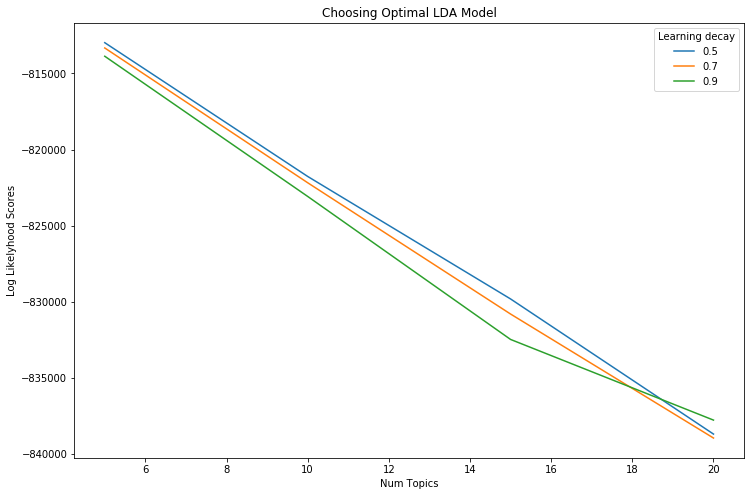

In [23]:
#Get Log Likelyhoods from Grid Search Output
n_topics = [5, 10, 15, 20]
log_likelyhoods_5 = [round(model.cv_results_['mean_test_score'][i]) for i in range(0,4)]
log_likelyhoods_7 = [round(model.cv_results_['mean_test_score'][i]) for i in range(4,8)]     
log_likelyhoods_9 = [round(model.cv_results_['mean_test_score'][i]) for i in range(8,12)]
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

In [24]:
data = df.content.values.tolist()

 to see the dominant topic in each document

In [25]:
# Document - Topic Matrix
lda_output = best_lda_model.transform(X)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(data))]

# converted to a pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'blue' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,dominant_topic
Doc0,0,0.2,0.06,0.64,0.11,3
Doc1,0.02,0.03,0.26,0.69,0,3
Doc2,0.09,0.18,0,0,0.72,4
Doc3,0.02,0.1,0,0.77,0.1,3
Doc4,0.03,0,0.07,0.83,0.07,3
Doc5,0,0,0,0.93,0.06,3
Doc6,0,0.8,0,0,0.19,1
Doc7,0,0.1,0.45,0.45,0,2
Doc8,0.26,0.17,0.36,0,0.21,2
Doc9,0.38,0.12,0.3,0.19,0,0


Review topics distribution across documents

In [26]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,3,6782
1,0,5392
2,4,4834
3,2,3422
4,1,2720


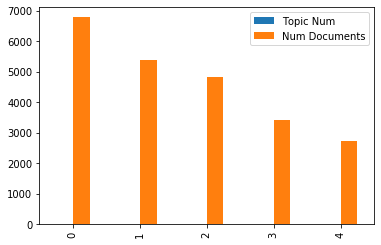

In [27]:
#topic_document distribution
df_topic_distribution.plot(kind='bar')

# LDA model with pyLDAvis

In [28]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, X, token_vectorizer, mds='tsne')
panel

/Users/shahrzad/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
3      182.213486 -136.551971       1        1  28.261022
0      175.745453  -55.445229       2        1  21.701425
4       43.251705  -82.834450       3        1  19.040686
2      103.634888 -133.228439       4        1  16.140054
1      102.597862  -27.174570       5        1  14.856812, topic_info=     Category         Freq        Term        Total  loglift  logprob
794   Default  4156.000000      finish  4156.000000  30.0000  30.0000
1584  Default  3927.000000        read  3927.000000  29.0000  29.0000
2217  Default  3709.000000       write  3709.000000  28.0000  28.0000
1559  Default  5657.000000    question  5657.000000  27.0000  27.0000
145   Default  2283.000000  assignment  2283.000000  26.0000  26.0000
960   Default  2545.000000    homework  2545.000000  25.0000  25.0000
100   Default  3643.000000      answer  3643.000000  24.0000  24.0000
400   Default  2726.000000    complete  2726.000000  23.0000  23.0000
1936  Default  5900.000000       study  5900.000000  22.0000  22.0000
1988  Default  1573.000000        talk  1573.000000  21.0000  21.0000
1566  Default  3827.000000        quiz  3827.000000  20.0000  20.0000
1586  Default  2590.000000     reading  2590.000000  19.0000  19.0000
1317  Default  4379.000000        note  4379.000000  18.0000  18.0000
154   Default  1200.000000   attention  1200.000000  17.0000  17.0000
1408  Default  1094.000000         pay  1094.000000  16.0000  16.0000
1415  Default   918.000000      people   918.000000  15.0000  15.0000
1996  Default  1718.000000     teacher  1718.000000  14.0000  14.0000
228   Default  1699.000000        book  1699.000000  13.0000  13.0000
1732  Default  1952.000000      school  1952.000000  12.0000  12.0000
2204  Default  1441.000000        word  1441.000000  11.0000  11.0000
1087  Default  1100.000000   knowledge  1100.000000  10.0000  10.0000
1612  Default   905.000000  reflection   905.000000   9.0000   9.0000
1903  Default  1232.000000        stay  1232.000000   8.0000   8.0000
1835  Default   726.000000       small   726.000000   7.0000   7.0000
2013  Default   805.000000        text   805.000000   6.0000   6.0000
1531  Default  1280.000000     project  1280.000000   5.0000   5.0000
900   Default   734.000000       group   734.000000   4.0000   4.0000
2103  Default  3561.000000  understand  3561.000000   3.0000   3.0000
2192  Default   624.000000         win   624.000000   2.0000   2.0000
1156  Default  2753.000000        look  2753.000000   1.0000   1.0000
...       ...          ...         ...          ...      ...      ...
1814   Topic5   118.079140         sit   132.694478   1.7900  -6.1374
1479   Topic5   252.841206        post   315.694187   1.6847  -5.3760
1136   Topic5   417.967293      listen   559.145959   1.6157  -4.8734
1913   Topic5   307.032310        stop   404.717340   1.6305  -5.1818
853    Topic5   236.136124        game   299.620236   1.6686  -5.4443
1531   Topic5   788.997768     project  1280.198087   1.4227  -4.2380
1996   Topic5   992.875117     teacher  1718.038376   1.3584  -4.0081
1432   Topic5   316.192142    personal   441.600915   1.5727  -5.1524
1719   Topic5   604.025264         say   975.788902   1.4271  -4.5051
675    Topic5   163.508856  enrichment   198.353902   1.7135  -5.8119
131    Topic5   322.677710      around   475.773012   1.5184  -5.1321
1456   Topic5   238.153958        play   327.324736   1.5887  -5.4358
1126   Topic5   194.447293        life   256.258623   1.6307  -5.6386
594    Topic5   275.091765    distract   452.029192   1.4101  -5.2916
841    Topic5   339.154194      friend   627.751380   1.2910  -5.0823
2223   Topic5   382.670695        year   874.149382   1.0806  -4.9616
138    Topic5   812.955663         ask  3646.161326   0.4060  -4.2081
99     Topic5   369.737711     another   989.076136   0.9227  -4.9960
1086   Topic5   631.126789        know  3139.879715

The weights of each keyword in each topic is contained in lda_model.components_ as a 2d array.

In [29]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = token_vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

df_topic_keywords.head()

,abduction,ability,absence,absent,absolute,absolutely,academic,academically,academy,acceleration,...,year,yell,yellow,yes,yesterday,yet,young,zachery,zero,zone
Topic0,0.200076,0.229082,14.185120,90.250200,3.177229,0.203039,167.135193,0.201915,35.929652,0.206878,...,214.949271,0.200650,0.208453,191.710247,61.518011,104.067092,0.587476,25.119125,81.472210,9.663228
Topic1,0.200004,23.713313,0.200900,5.005796,28.208220,6.504998,154.252382,19.147397,6.688493,5.863077,...,374.981723,18.198139,2.177112,72.244534,12.804575,23.485407,9.733751,5.277729,15.550818,11.856245
Topic2,11.196981,46.655116,0.213398,6.507790,0.202038,0.208633,2.192257,12.248639,0.202308,5.746950,...,185.321291,0.200456,0.202063,0.201827,4.880516,109.242274,5.466218,0.200920,1.492400,1.988468
Topic3,0.202935,152.726941,0.200454,10.034229,0.211335,6.831671,0.201397,0.201213,19.977015,3.983086,...,35.682152,0.200210,4.318470,47.248515,14.595488,38.552260,5.011128,0.200666,17.283643,0.240775
Topic4,0.200004,41.675549,0.200127,0.201985,0.201179,1.251660,0.218772,0.200837,0.202531,0.200009,...,57.065563,0.200545,7.093903,66.594878,0.201411,26.652967,0.201427,0.201560,0.200929,5.251284


to see the top 15 keywords that are representative of the topic.

In [30]:
# Show top n keywords for each topic
def show_topics(vectorizer=token_vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=token_vectorizer, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,finish,homework,complete,assignment,school,ask,day,stay,keep,focus,study,reflection,home,test,extra
Topic 1,talk,attention,pay,teacher,people,ask,project,group,know,say,art,language,test,something,listen
Topic 2,read,reading,small,score,book,win,last,much,pretty,quiz,something,point,start,day,line
Topic 3,study,note,question,quiz,understand,test,take,check,answer,learn,problem,practice,look,ask,review
Topic 4,write,read,question,answer,reading,look,word,book,text,story,understand,idea,evidence,back,essay


In [31]:
panel = pyLDAvis.sklearn.prepare(best_lda_model, X, token_vectorizer, mds='mmds')
panel

/Users/shahrzad/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.120031 -0.173104       1        1  28.261022
0     -0.026091  0.250681       2        1  21.701425
4     -0.128711 -0.226457       3        1  19.040686
2     -0.158563  0.037296       4        1  16.140054
1      0.193333  0.111584       5        1  14.856812, topic_info=     Category         Freq        Term        Total  loglift  logprob
794   Default  4156.000000      finish  4156.000000  30.0000  30.0000
1584  Default  3927.000000        read  3927.000000  29.0000  29.0000
2217  Default  3709.000000       write  3709.000000  28.0000  28.0000
1559  Default  5657.000000    question  5657.000000  27.0000  27.0000
145   Default  2283.000000  assignment  2283.000000  26.0000  26.0000
960   Default  2545.000000    homework  2545.000000  25.0000  25.0000
100   Default  3643.000000      answer  3643.000000  24.0000  24.0000
400   Default  2726.000000    complete  2726.000000  23.0000  23.0000
1936  Default  5900.000000       study  5900.000000  22.0000  22.0000
1988  Default  1573.000000        talk  1573.000000  21.0000  21.0000
1566  Default  3827.000000        quiz  3827.000000  20.0000  20.0000
1586  Default  2590.000000     reading  2590.000000  19.0000  19.0000
1317  Default  4379.000000        note  4379.000000  18.0000  18.0000
154   Default  1200.000000   attention  1200.000000  17.0000  17.0000
1408  Default  1094.000000         pay  1094.000000  16.0000  16.0000
1415  Default   918.000000      people   918.000000  15.0000  15.0000
1996  Default  1718.000000     teacher  1718.000000  14.0000  14.0000
228   Default  1699.000000        book  1699.000000  13.0000  13.0000
1732  Default  1952.000000      school  1952.000000  12.0000  12.0000
2204  Default  1441.000000        word  1441.000000  11.0000  11.0000
1087  Default  1100.000000   knowledge  1100.000000  10.0000  10.0000
1612  Default   905.000000  reflection   905.000000   9.0000   9.0000
1903  Default  1232.000000        stay  1232.000000   8.0000   8.0000
1835  Default   726.000000       small   726.000000   7.0000   7.0000
2013  Default   805.000000        text   805.000000   6.0000   6.0000
1531  Default  1280.000000     project  1280.000000   5.0000   5.0000
900   Default   734.000000       group   734.000000   4.0000   4.0000
2103  Default  3561.000000  understand  3561.000000   3.0000   3.0000
2192  Default   624.000000         win   624.000000   2.0000   2.0000
1156  Default  2753.000000        look  2753.000000   1.0000   1.0000
...       ...          ...         ...          ...      ...      ...
1814   Topic5   118.079140         sit   132.694478   1.7900  -6.1374
1479   Topic5   252.841206        post   315.694187   1.6847  -5.3760
1136   Topic5   417.967293      listen   559.145959   1.6157  -4.8734
1913   Topic5   307.032310        stop   404.717340   1.6305  -5.1818
853    Topic5   236.136124        game   299.620236   1.6686  -5.4443
1531   Topic5   788.997768     project  1280.198087   1.4227  -4.2380
1996   Topic5   992.875117     teacher  1718.038376   1.3584  -4.0081
1432   Topic5   316.192142    personal   441.600915   1.5727  -5.1524
1719   Topic5   604.025264         say   975.788902   1.4271  -4.5051
675    Topic5   163.508856  enrichment   198.353902   1.7135  -5.8119
131    Topic5   322.677710      around   475.773012   1.5184  -5.1321
1456   Topic5   238.153958        play   327.324736   1.5887  -5.4358
1126   Topic5   194.447293        life   256.258623   1.6307  -5.6386
594    Topic5   275.091765    distract   452.029192   1.4101  -5.2916
841    Topic5   339.154194      friend   627.751380   1.2910  -5.0823
2223   Topic5   382.670695        year   874.149382   1.0806  -4.9616
138    Topic5   812.955663         ask  3646.161326   0.4060  -4.2081
99     Topic5   369.737711     another   989.076136   0.9227  -4.9960
1086   Topic5   631.126789        know  3139.879715   0.3023  -4.4612
2004   To